# *Pré-processamento*

Nessa parte, o objetivo é trabalhar com os dados de forma que eles tenham a qualidade apropriada para a análise prescritiva, exploratória e preditiva, assim, passamos por aluns processos para reduzir a multidimensionalidade e consolidar a base de dados, trabalhar com os diferentes datatypes, tratar nulos, outliers, criar novas variáveis de interesse, entre outros.
Portanto, quando finalizada essa etapa, o resultado esperado é a obtençao de um cubo de dados que sejam relevantes para a análise de risco em crédito no Brasil, com foco em inadimplencia, ou seja, nossa variável quantitativa e indicador principal é o over15. 
A fonte dos dados foi coletada dos dados abertos do Banco Central do Brasil, conforme fonte: [(https://dadosabertos.bcb.gov.br/dataset/scr_data](https://dadosabertos.bcb.gov.br/dataset/scr_data)

In [1]:
## Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

##Ignora os erros.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")


In [2]:
%matplotlib inline

In [7]:
## Cria um ambiente inicial em spark para teste do ambiente. 
## Temos os dados de crédito para um espaço de cerca de 12 anos, contendo informaçoes sobre as operaçoes de crédito no Brasil de PF e PJ.
## Informaçoes que considero relevantes para a o objetivo do projeto sao principalmente a série istórica e os indicadores de carteira ativa e inadimplencia vencida acima de 15 dias. Nesse intervalo temos uma carteira de crédito característica de atraso em eral.
## Para uma possível análise exploratória, é interessante fazer ranulometrias por estado, porte das empresas, modalidade e CNAE.
## Uma visao foto para momentos é interessante para a análise, pois nos ajuda a comparar a a realidade do crédito no Brasil em diferentes momentos.
## É interessante também comparar os resultados obtidos com o de países emerentes como Arentina, Cina, Rússia, ìndia e África do Sul.
## Também, para uma ranulometria nacional, é interessante destacar a necessidade de trazer outros indicadores socioeconomicos e ambientais que possam arear a visao de riscos. 

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.read.csv('C:/Users/User/OneDrive - usp.br/Área de Trabalho/USP/TCC/bacen/planilha_202404.csv', header=True,sep= ';').show()
df = spark.read.csv('C:/Users/User/OneDrive - usp.br/Área de Trabalho/USP/TCC/bacen/planilha_202404.csv', header=True,sep= ';')

+----------+---+--------+---+-------+--------------------+----------+--------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+---------------------------+-----------------------------+------------------------------+------------------------------+---------------------------+------------------------+--------------+------------------------------+------------------+
| data_base| uf|     tcb| sr|cliente|            ocupacao|cnae_secao|cnae_subclasse|               porte|          modalidade|              origem|         indexador|numero_de_operacoes|a_vencer_ate_90_dias|a_vencer_de_91_ate_360_dias|a_vencer_de_361_ate_1080_dias|a_vencer_de_1081_ate_1800_dias|a_vencer_de_1801_ate_5400_dias|a_vencer_acima_de_5400_dias|vencido_acima_de_15_dias|carteira_ativa|carteira_inadimplida_arrastada|ativo_problematico|
+----------+---+--------+---+-------+--------------------+----------+--------------+--------------------+---

In [9]:
print(df.printSchema())

root
 |-- data_base: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- tcb: string (nullable = true)
 |-- sr: string (nullable = true)
 |-- cliente: string (nullable = true)
 |-- ocupacao: string (nullable = true)
 |-- cnae_secao: string (nullable = true)
 |-- cnae_subclasse: string (nullable = true)
 |-- porte: string (nullable = true)
 |-- modalidade: string (nullable = true)
 |-- origem: string (nullable = true)
 |-- indexador: string (nullable = true)
 |-- numero_de_operacoes: string (nullable = true)
 |-- a_vencer_ate_90_dias: string (nullable = true)
 |-- a_vencer_de_91_ate_360_dias: string (nullable = true)
 |-- a_vencer_de_361_ate_1080_dias: string (nullable = true)
 |-- a_vencer_de_1081_ate_1800_dias: string (nullable = true)
 |-- a_vencer_de_1801_ate_5400_dias: string (nullable = true)
 |-- a_vencer_acima_de_5400_dias: string (nullable = true)
 |-- vencido_acima_de_15_dias: string (nullable = true)
 |-- carteira_ativa: string (nullable = true)
 |-- carteira_inad

In [ ]:
## Importaçao de bibliotecas para trabalar com funçoes de correçao, datatypes e sistema operacional.
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, DateType
from pyspark.sql.functions import regexp_replace, col, when, round, sum as _sum ## Possível erro. 

## Retorna uma lista com todos os caminos dos arquivos do database no OneDrive, para leitura e incorporaçao dos mesmos.
def get_csv_file_paths(root_dir):
    csv_file_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv"):
                csv_file_paths.append(os.path.join(root, file))
    return csv_file_paths

## Inicia a sessão Spark 
spark = SparkSession.builder \
    .appName("Cube") \
    .getOrCreate()

## Diretório raiz onde os arquivos CSV estão localizados
root_dir = "C:/Users/User/OneDrive - usp.br/Área de Trabalho/USP/TCC/bacen"

## Captura a lista de caminhos para os arquivos CSV
csv_paths = get_csv_file_paths(root_dir)

## Definir o esquema explícito, ou seja, aqui definimos os tipos de dados para cada feature, ou variável, seja contínua ou discreta.
schema = StructType([
    StructField("data_base", DateType(), True),
    StructField("uf", StringType(), True),
    StructField("tcb", StringType(), True),
    StructField("sr", StringType(), True),
    StructField("cliente", StringType(), True),
    StructField("ocupacao", StringType(), True),
    StructField("cnae_secao", StringType(), True),
    StructField("cnae_subclasse", StringType(), True),
    StructField("porte", StringType(), True),
    StructField("modalidade", StringType(), True),
    StructField("origem", StringType(), True),
    StructField("indexador", StringType(), True),
    StructField("numero_de_operacoes", StringType(), True),
    StructField("a_vencer_ate_90_dias", StringType(), True),
    StructField("a_vencer_de_91_ate_360_dias", StringType(), True),
    StructField("a_vencer_de_361_ate_1080_dias", StringType(), True),
    StructField("a_vencer_de_1081_ate_1800_dias", StringType(), True),
    StructField("a_vencer_de_1801_ate_5400_dias", StringType(), True),
    StructField("a_vencer_acima_de_5400_dias", StringType(), True),
    StructField("vencido_acima_de_15_dias", StringType(), True),
    StructField("carteira_ativa", StringType(), True),
    StructField("carteira_inadimplida_arrastada", StringType(), True),
    StructField("ativo_problematico", StringType(), True)
])

## Le múltiplos arquivos CSV usando a lista de caminhos com esquema explícito
df = spark.read.csv(csv_paths, header=True, schema=schema, sep=';')

## Substitui pontos por vírgulas nas colunas necessárias. Essa correçao só foi necessária para as variáveis quantitativas contínuas.
float_columns = [
    "a_vencer_ate_90_dias", "a_vencer_de_91_ate_360_dias", "a_vencer_de_361_ate_1080_dias",
    "a_vencer_de_1081_ate_1800_dias", "a_vencer_de_1801_ate_5400_dias", "a_vencer_acima_de_5400_dias",
    "vencido_acima_de_15_dias", "carteira_ativa", "carteira_inadimplida_arrastada", "ativo_problematico"
]

for column in float_columns:
    df = df.withColumn(column, regexp_replace(col(column), ",", ".").cast('float'))
    df = df.withColumn(column, round(col(column), 2))

## Substitui valores menores ou iguais a 15 por 15 e converter para inteiro.
## Essa correçao foi necessária devido ao número de operaçoes ser uma variável quantitativa nominal, e por isso, ser classificada como inteiro.
## Assim, assumimos como premissa que o menor número de operaçoes é 15. Dessa forma, PMEs que tenam menos operaçoes, por serem muito baixos, nao defasem na somatória. 
df = df.withColumn('numero_de_operacoes', when(col('numero_de_operacoes') == "<= 15", 15).otherwise(col('numero_de_operacoes').cast(IntegerType())))

## Filtro para carteira PJ
## Para o estudo de caso, trabalaremos somente com PMEs.
df = df.filter("cliente = 'PJ'")
## Filtro porte da empresa
df = df.filter("porte IN ('PJ - Médio                                   ', 'PJ - Micro                                   ', 'PJ - Pequeno                                 ')")

## Cria o cubo usando a função cube com múltiplas agregações
## Aqui, criamos nossa variável y, ou a feature que entendemos como alvo, ou taret. Nosso over15.
## Aqui, ao montarmos o cubo agregando os dados, reduzimos a dimensionalidade da informaçao, de forma que tenamos uma série istórica.
## Como faremos duas análises aqui, uma prescritiva exploratória e uma preditiva, teremos que criar dois cubos separados com a granulometria necessária para cada objetivo específico.
cube = df.cube("data_base").agg(
    _sum("carteira_ativa").alias("total_carteira_ativa"),
    _sum("vencido_acima_de_15_dias").alias("total_vencido_acima_de_15_dias")
)

## Filtrar e mostrar resultados onde data_base não é nulo
## Remove valores nulos que possam defasar os dados. Os valores nulos eram baixos o suficiente para lidar dessa forma.
cube = cube.filter("data_base IS NOT NULL")

## Feature engineering -> Criar a coluna de percentual de Over15
cube = cube.withColumn("over_15", 
                       (cube["total_vencido_acima_de_15_dias"] / cube["total_carteira_ativa"]) * 100)

## Drop das colunas que nao serao utilizadas para a série temporal
cube = cube.drop('carteira_ativa','vencido_acima_de_15_dias')

## Ordem decrescente
## Por ser uma série istórica, precisamos de uma ordem específica.
cube.orderBy("data_base", ascending=True)

# Converter e salva o DataFrame PySpark para Pandas
cube_pandas = cube.toPandas()
cube_pandas.to_csv('C:/Users/User/OneDrive - usp.br/Área de Trabalho/USP/TCC/cubes/cubo_total', index=False, sep=';')
print(cube_pandas.head())

# Parar a sessão Spark
spark.stop()

    data_base  total_carteira_ativa  total_vencido_acima_de_15_dias   over_15
0  2012-06-30          6.108586e+11                    1.694424e+10  2.773841
1  2012-07-31          6.196225e+11                    1.760706e+10  2.841578
2  2012-08-31          6.213316e+11                    1.796467e+10  2.891318
3  2012-09-30          6.207200e+11                    1.686934e+10  2.717705
4  2012-10-31          6.414463e+11                    1.725200e+10  2.689547


# Análise Exploratória 

Com a base de dados, podemos realizar  uma  análise exploratória  para entender melhor a série. No presente trabalo, como estamos explorando uma série temporal, iremos começar com a visualizaçao de dados, usando boxplots, histogramas e gráficos de linha para entendendo seu comportamento, e identificando padroes. Também, usamos estatísticas  descritivas para entender a distribuiçao da série no tempo, sua autocorrelaçao, estacionaridade e decompomos a série em suas componententes de ciclo, ruído, sazonalidade e tendência. 

## Estatísticas descritivas

----------------------------------------------------------------------------------------------------
Amostragem
----------------------------------------------------------------------------------------------------
    data_base  total_carteira_ativa  total_vencido_acima_de_15_dias   over_15
0  2012-06-30          6.108586e+11                    1.694424e+10  2.773841
1  2012-07-31          6.196225e+11                    1.760706e+10  2.841578
2  2012-08-31          6.213316e+11                    1.796467e+10  2.891318
3  2012-09-30          6.207200e+11                    1.686934e+10  2.717705
4  2012-10-31          6.414463e+11                    1.725200e+10  2.689547
----------------------------------------------------------------------------------------------------
Info
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 4 columns):
 #   Col

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


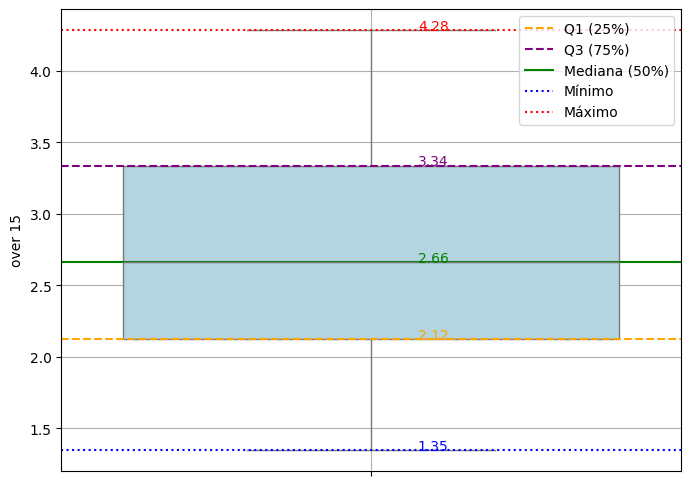

Valores Calculados
Q1: 2.1219779898352975, Q3: 3.3375636420490054, Mediana: 2.6621610017707, Mínimo: 1.3484951999297543, Máximo: 4.284587141940474


In [75]:
## oranizar as bibliotecas.
## Importação das bibliotecas
from scipy.stats import shapiro, anderson, jarque_bera, kstest, norm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import seaborn as sns

## Função para leitura dos dados, utilizando cunks, para otimizar a leitura.
def loadData(file):
    chunks = []
    for chunk in pd.read_csv(file, low_memory=True, chunksize=1000, sep=';', encoding='UTF-8'):
        chunks.append(chunk)
    df = pd.concat(chunks)
    return df

## Leitura do dataset
df = loadData('C:/Users/User/OneDrive - usp.br/Área de Trabalho/USP/TCC/cubes/cubo_total')

## Visualização das estatísticas básicas
print(100*"-")
print("Amostragem")
print(100*"-")
print(df.head())

print(100*"-")
print("Info")
print(100*"-")
print(df.info())

## Como estamos olando apenas para a série temporal, vamos separar apenas a série, transformando as datas para o formato correto e resetando o indíce.
df['data_base'] = pd.to_datetime(df['data_base'])
df.set_index('data_base', inplace=True)

## Assim, temos uma série temporal com um índice de data.
series = df['over_15'] 

# Cálculo dos valores importantes
Q1 = np.percentile(series, 25)  # Primeiro quartil (Q1 - 25%)
Q3 = np.percentile(series, 75)  # Terceiro quartil (Q3 - 75%)
median = np.percentile(series, 50)  # Mediana (50%)
minimum = np.min(series)  # Mínimo
maximum = np.max(series)  # Máximo

# Boxplot
plt.figure(figsize=(8, 6))  # Definir o tamanho da figura
sns.boxplot(data=series, color='lightblue')  # Boxplot da série com cor azul clara

# Adicionando as marcações no gráfico
plt.axhline(Q1, color='orange', linestyle='--', label='Q1 (25%)')
plt.axhline(Q3, color='purple', linestyle='--', label='Q3 (75%)')
plt.axhline(median, color='green', linestyle='-', label='Mediana (50%)')
plt.axhline(minimum, color='blue', linestyle=':', label='Mínimo')
plt.axhline(maximum, color='red', linestyle=':', label='Máximo')

# Adicionando os valores ao gráfico, alinhando com as linhas
plt.text(0.1, Q1, f'{Q1:.2f}', color='orange', fontsize=10, ha='center')
plt.text(0.1, Q3, f'{Q3:.2f}', color='purple', fontsize=10, ha='center')
plt.text(0.1, median, f'{median:.2f}', color='green', fontsize=10, ha='center')
plt.text(0.1, minimum, f'{minimum:.2f}', color='blue', fontsize=10, ha='center')
plt.text(0.1, maximum, f'{maximum:.2f}', color='red', fontsize=10, ha='center')

# Definir título e rótulos do gráfico
plt.ylabel('over 15')  # Rótulo do eixo Y
plt.grid(True)  # Exibir grade no gráfico
plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.show()

# Exibir os valores calculados
print("Valores Calculados")
print(f"Q1: {Q1}, Q3: {Q3}, Mediana: {median}, Mínimo: {minimum}, Máximo: {maximum}")

## Visualizaçao Inicial

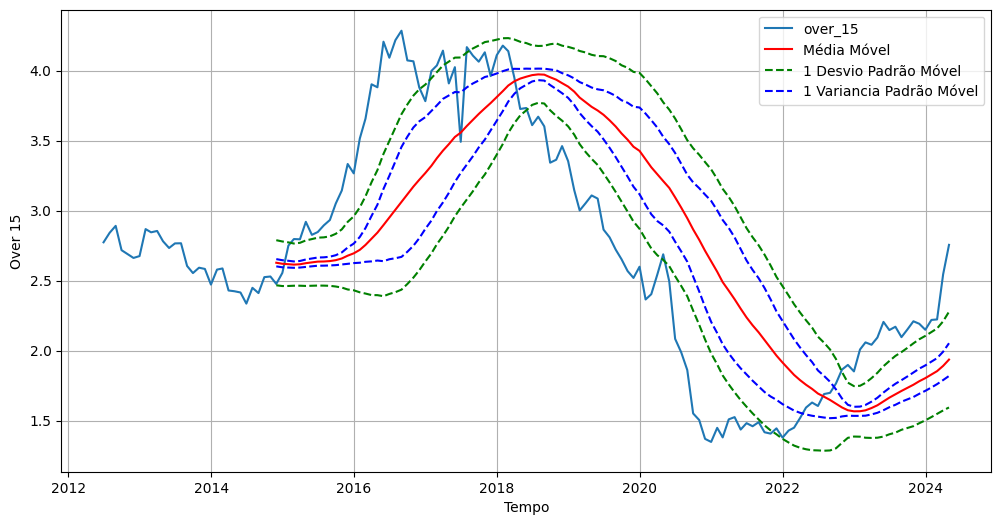

Estatística ADF: -2.173168217112373
p-valor: 0.21612754808006684
Valores críticos:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


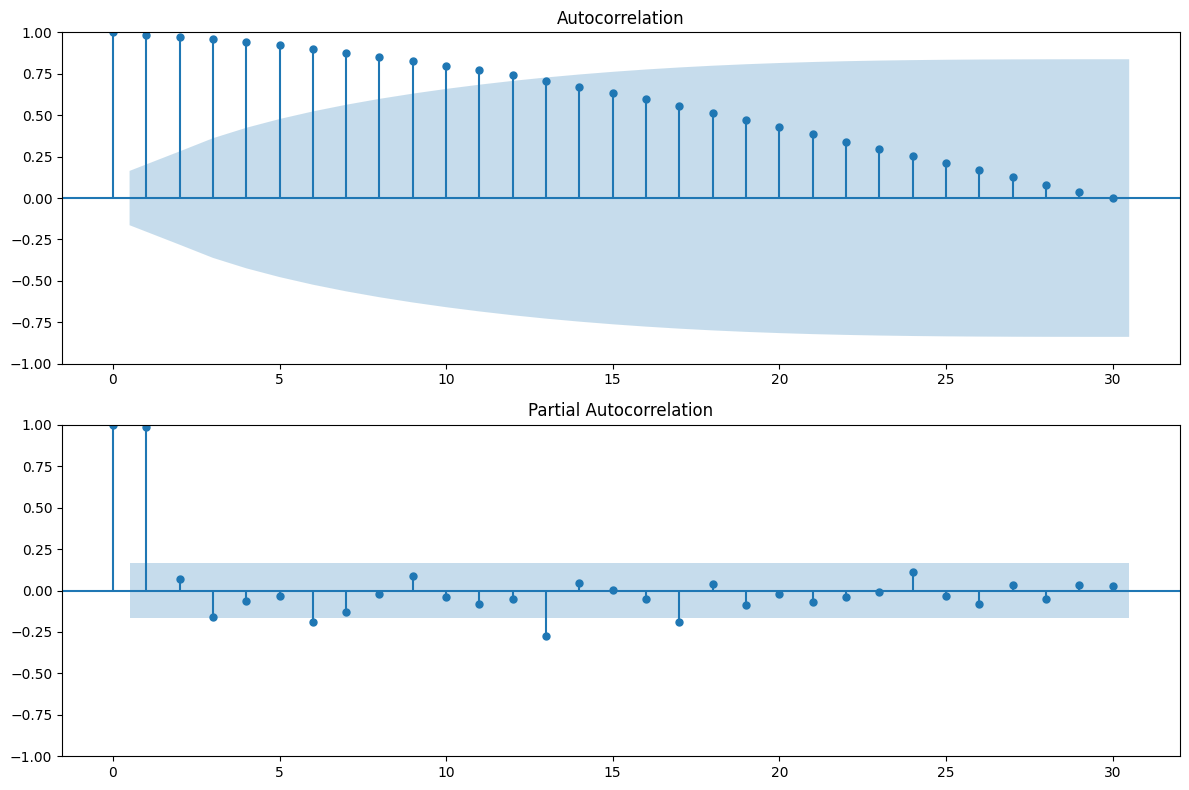

In [78]:
## Função para visualizar a série temporal com média móvel, variância e desvio padrão móveis. 
## Análise inicial da série de inadimplencia.
def plot_time_series_with_rolling_statistics(series, window=30):
    
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    rolling_var = series.rolling(window=window).var()
    
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='over_15')
    plt.plot(rolling_mean, color='red', label='Média Móvel')
    plt.plot(rolling_mean + rolling_std, color='green', linestyle='--', label='1 Desvio Padrão Móvel')
    plt.plot(rolling_mean - rolling_std, color='green', linestyle='--')
    plt.plot(rolling_mean + rolling_var, color='blue', linestyle='--', label='1 Variancia Padrão Móvel')
    plt.plot(rolling_mean - rolling_var, color='blue', linestyle='--')
    plt.xlabel('Tempo')
    plt.ylabel('Over 15')
    plt.legend()
    plt.grid(True)
    plt.show()

## Plotagem
plot_time_series_with_rolling_statistics(series)

# Função para verificar a estacionariedade usando o teste ADF
## ADF Teste **. 
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('Estatística ADF:', result[0])
    print('p-valor:', result[1])
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

check_stationarity(series)

## Autocorrelaçao e correlaçao parcial da série. 
# Função para plotar ACF e PACF
def plot_acf_pacf(series, lags=30):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(series.dropna(), lags=lags, ax=ax[0])
    sm.graphics.tsa.plot_pacf(series.dropna(), lags=lags, ax=ax[1])
    plt.tight_layout()
    plt.show()

plot_acf_pacf(series)

## Diferenciaçao.

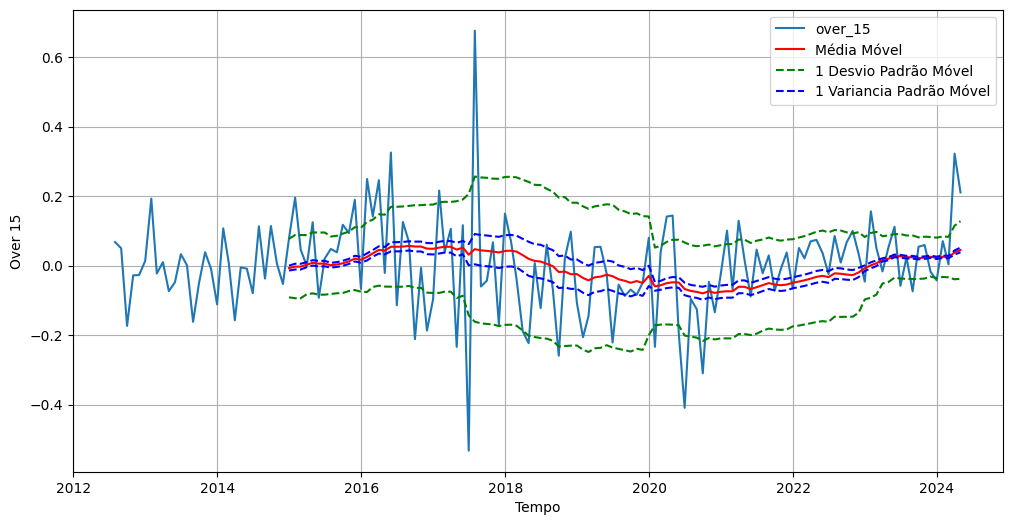

Estatística ADF: -7.012396869080002
p-valor: 6.868229263368548e-10
Valores críticos:
   1%: -3.4779446621720114
   5%: -2.8824156122448983
   10%: -2.577901887755102


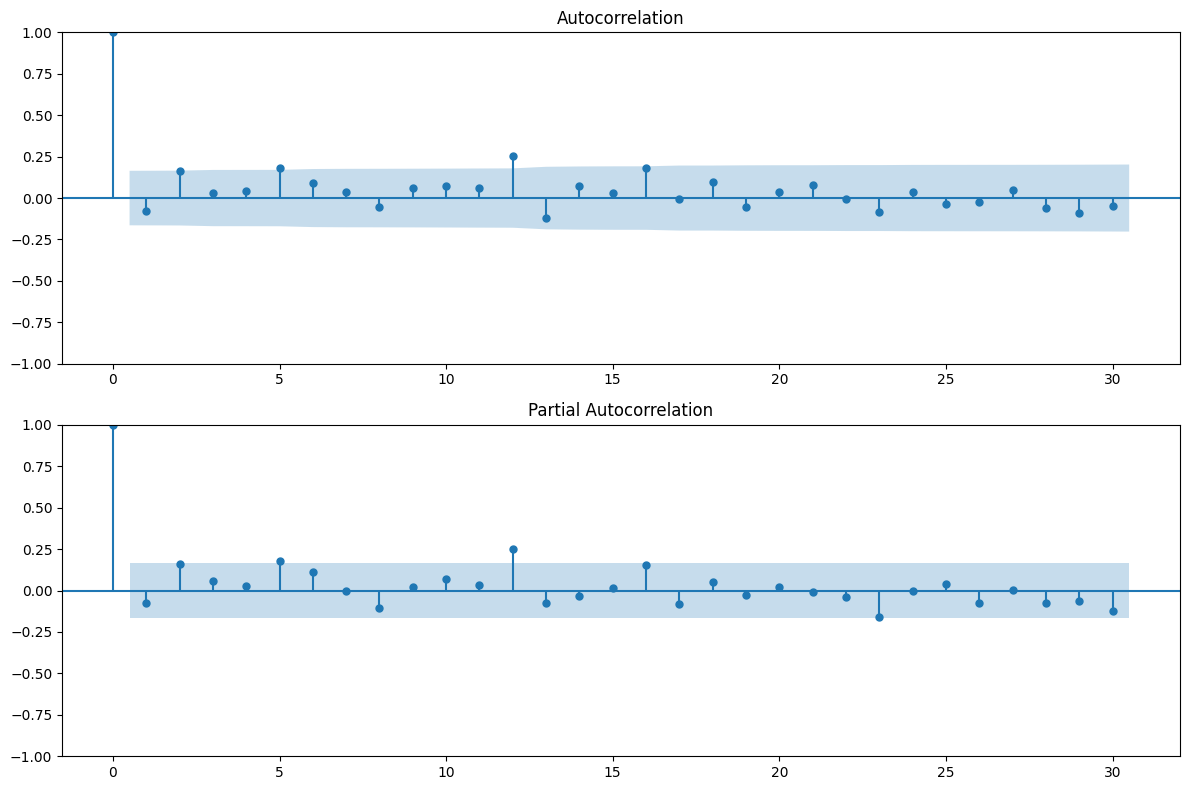

In [79]:
## Diferenciaçao

## Diferenciaçao. Colocar em um separado.
# Se a série não for estacionária, você pode diferenciar e verificar novamente
series_diff = series.diff().dropna()
plot_time_series_with_rolling_statistics(series_diff) 
check_stationarity(series_diff)
plot_acf_pacf(series_diff)

## Decomposição 

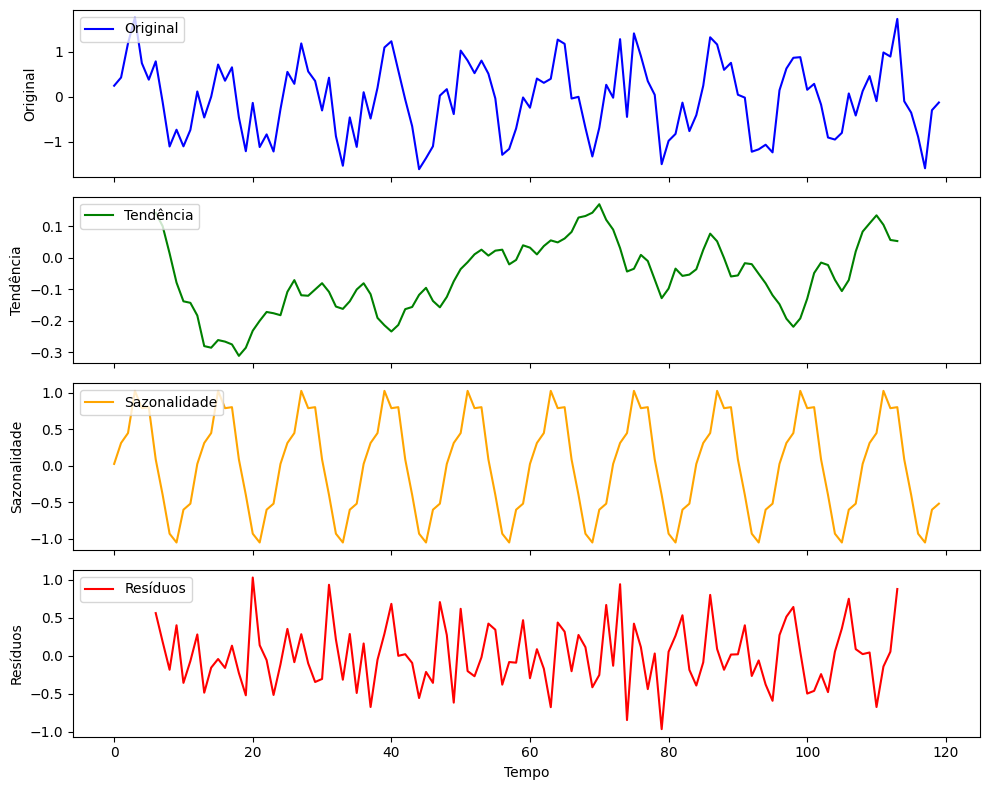

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Gerando uma série fictícia para simular 'series_diff'
np.random.seed(42)
time = np.arange(120)
series_diff = np.sin(2 * np.pi * time / 12) + np.random.normal(0, 0.5, 120)

# Decomposição da série temporal
decomposition = seasonal_decompose(series_diff, model='additive', period=12)

# Separando os componentes da decomposição
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Configuração da resolução do gráfico
plt.rcParams.update({'figure.figsize': (10, 8), 'figure.dpi': 100})

# Plotando os componentes individualmente
fig, axes = plt.subplots(4, 1, sharex=True)

axes[0].plot(series_diff, label='Original', color='blue')
axes[0].legend(loc='upper left')
axes[0].set_ylabel('Original')

axes[1].plot(trend, label='Tendência', color='green')
axes[1].legend(loc='upper left')
axes[1].set_ylabel('Tendência')

axes[2].plot(seasonal, label='Sazonalidade', color='orange')
axes[2].legend(loc='upper left')
axes[2].set_ylabel('Sazonalidade')

axes[3].plot(residual, label='Resíduos', color='red')
axes[3].legend(loc='upper left')
axes[3].set_ylabel('Resíduos')
axes[3].set_xlabel('Tempo')

plt.tight_layout()

# Caminho para salvar a figura
image_path = "C:/Users/User/OneDrive - usp.br/Área de Trabalho/USP/TCC/decomposiçao.png"

# Salvando a figura como imagem
plt.savefig(image_path, bbox_inches='tight', dpi=300)

# Exibindo a figura
plt.show()


## Tendencia


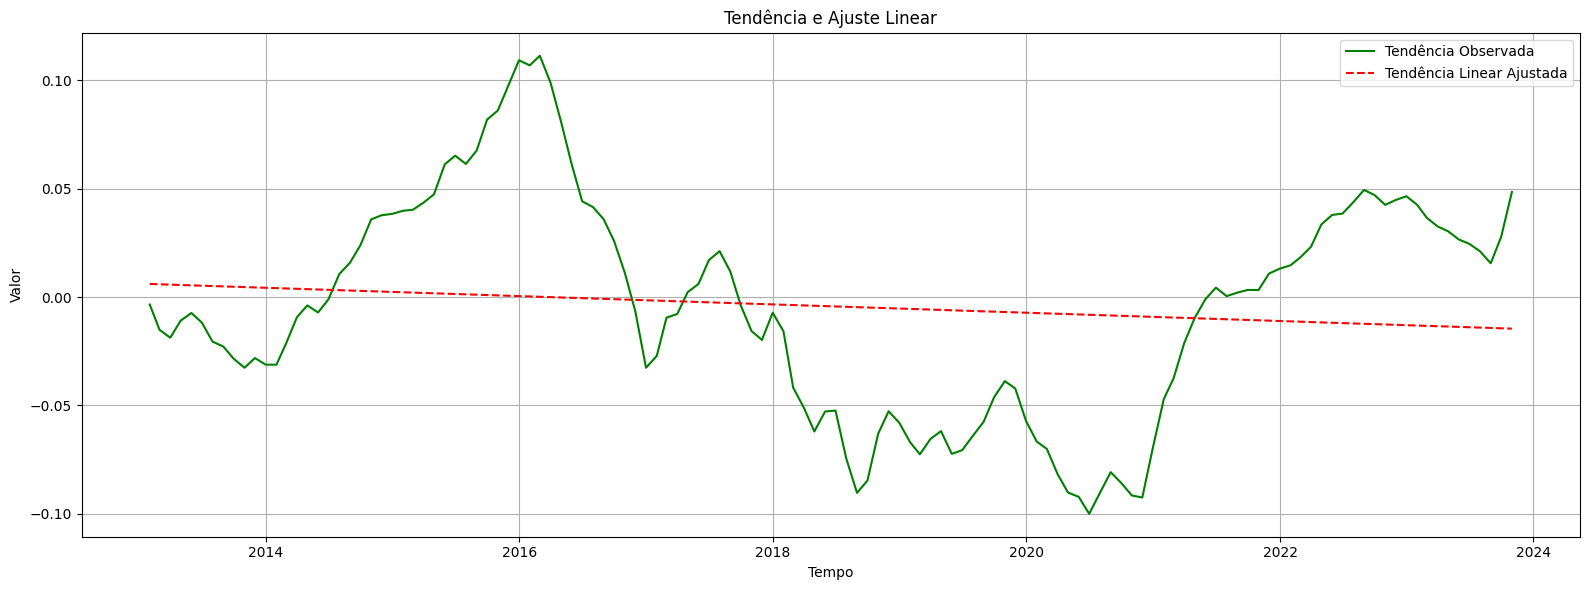

Coeficiente Angular (Inclinação): -0.0002
Intercepto: 0.0061


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

# Supondo que 'series_diff' seja sua série temporal já diferenciada

# Decomposição da série temporal
decomposition = seasonal_decompose(series_diff, model='additive', period=12)

# Separando a tendência
trend = decomposition.trend

# Remover valores nulos da tendência para ajustar a regressão linear
trend_non_null = trend.dropna()

# Criando variáveis para regressão linear
time_index = np.arange(len(trend_non_null)).reshape(-1, 1)  # Índice temporal
trend_values = trend_non_null.values  # Valores da tendência

# Ajustar regressão linear
linear_model = LinearRegression()
linear_model.fit(time_index, trend_values)

# Previsões da tendência linear
trend_linear_fit = linear_model.predict(time_index)

# Plotar a tendência real e a ajustada
plt.figure(figsize=(16, 6))

# Plotar a tendência observada
plt.plot(trend_non_null.index, trend_non_null, label='Tendência Observada', color='green')

# Plotar a tendência ajustada linearmente
plt.plot(trend_non_null.index, trend_linear_fit, label='Tendência Linear Ajustada', color='red', linestyle='--')
s
# Configurar título e legendas
plt.title('Tendência e Ajuste Linear')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exibir coeficientes da regressão
print(f"Coeficiente Angular (Inclinação): {linear_model.coef_[0]:.4f}")
print(f"Intercepto: {linear_model.intercept_:.4f}")

## Sazonalidade

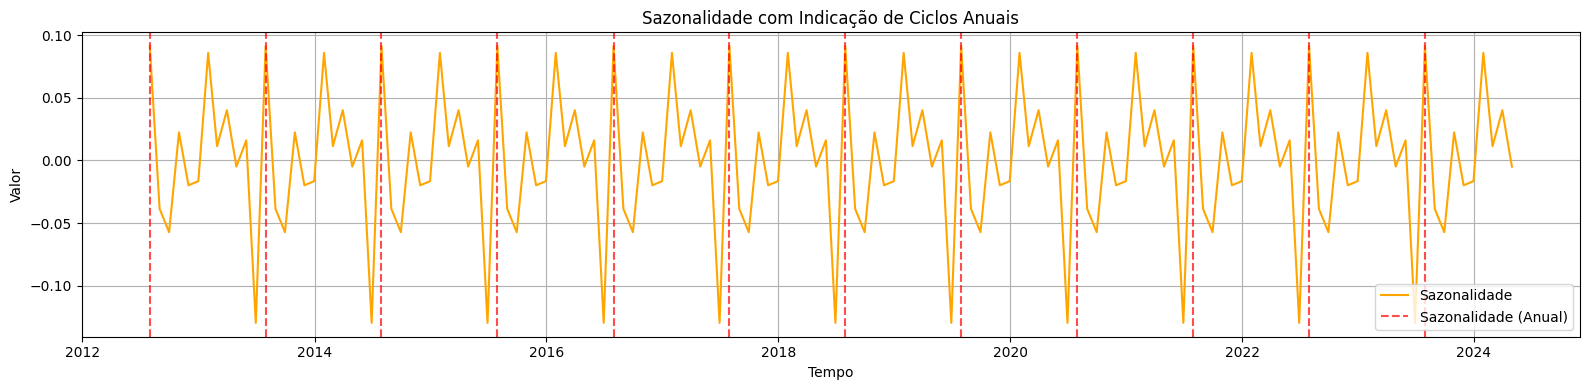

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Supondo que 'series_diff' seja sua série temporal já diferenciada

# Decomposição da série temporal
decomposition = seasonal_decompose(series_diff, model='additive', period=12)

# Separando os componentes
seasonal = decomposition.seasonal

# Determinar os índices para sazonalidade anual (a cada 12 meses)
sazonal_indices = np.arange(0, len(series_diff), step=12)

# Plotar apenas a sazonalidade com linhas verticais
plt.figure(figsize=(16, 4))

# Plotar a sazonalidade
plt.plot(seasonal, label='Sazonalidade', color='orange')

# Adicionar linhas verticais para indicar sazonalidade anual
for idx in sazonal_indices:
    if idx < len(series_diff):  # Garantir que não ultrapassamos o tamanho da série
        plt.axvline(x=series_diff.index[idx], color='red', linestyle='--', alpha=0.7, label='Sazonalidade (Anual)' if idx == sazonal_indices[0] else "")

# Configurar título e legendas
plt.title('Sazonalidade com Indicação de Ciclos Anuais')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Resíduo

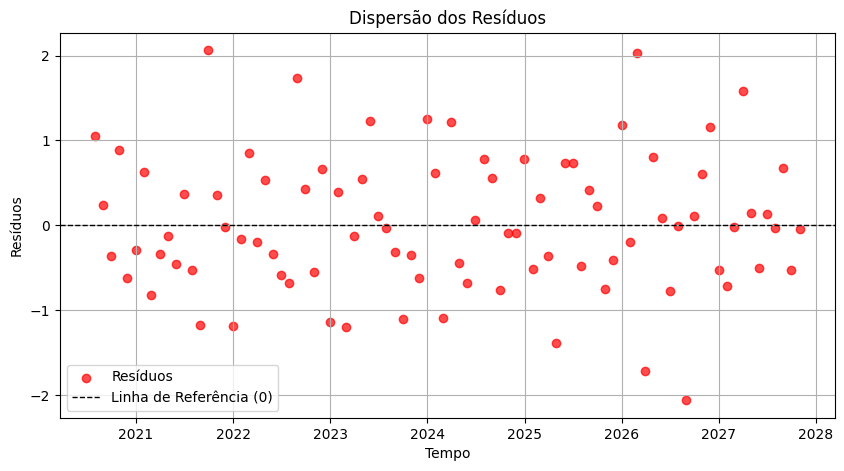

ShapiroResult(statistic=0.9894323348999023, pvalue=0.7034484148025513)

In [71]:
# Correção do código para focar no residual e sua dispersão

# Plotando a dispersão dos resíduos
plt.figure(figsize=(10, 5))
plt.scatter(residual_clean.index, residual_clean, alpha=0.7, color='red', label='Resíduos')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Linha de Referência (0)')
plt.title('Dispersão dos Resíduos')
plt.xlabel('Tempo')
plt.ylabel('Resíduos')
plt.legend()
plt.grid(True)
plt.show()

# Teste de normalidade Shapiro-Wilk
shapiro_test = shapiro(residual_clean)
shapiro_test


# Treinamento dos modelos

Depois de feita a análise exploratória nos dados, os modelos podem ser treinados e avaliados, para que possamos verificar se eles estao se ajustando corretamente às informaçoes, para depois, ser possível a utilização deles para fazer extrapolaçoes. 

## Treino e Teste

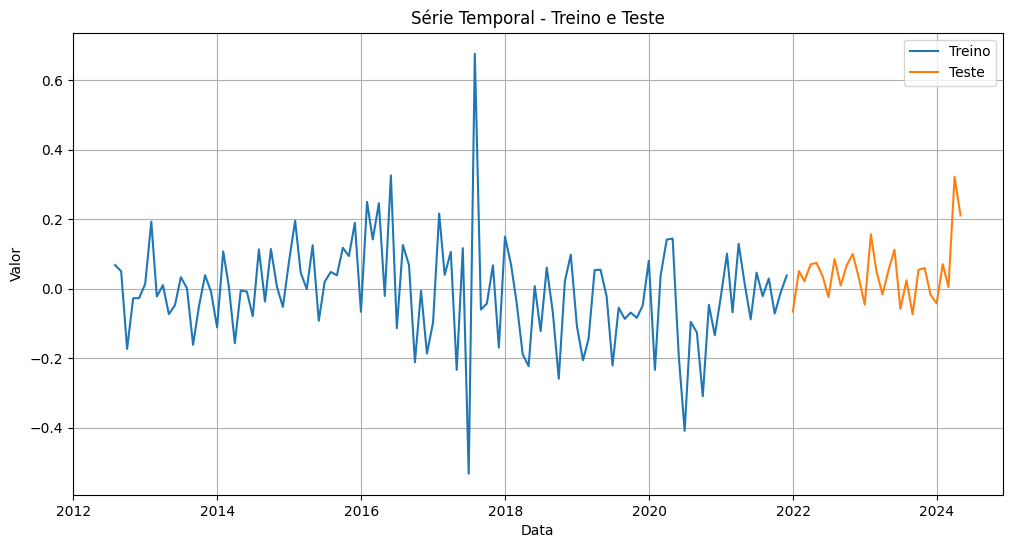

In [26]:
# Importação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# Ignorar avisos
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# Função para leitura dos dados
def loadData(file):
    chunks = []
    for chunk in pd.read_csv(file, low_memory=True, chunksize=1000, sep=',', encoding='UTF-8'):
        chunks.append(chunk)
    df = pd.concat(chunks)
    return df

# Leitura do dataset
df = loadData('C:/Users/User/OneDrive - usp.br/Área de Trabalho/USP/TCC/cubes/cubo_total_diff.csv')

# Assumindo que a série temporal está na coluna 'over_15_diff' e o índice de tempo está na coluna 'data_base'
df['data_base'] = pd.to_datetime(df['data_base'])
df.set_index('data_base', inplace=True)

# Seleciona a série temporal
series = df['over_15_diff'].dropna()

# Separação em treino e teste (80% treino, 20% teste)
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# Função para plotar série temporal com treino e teste
def plot_train_test(train, test, title=''):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()
## Separaçao do conjunto de dados
plot_train_test(train, test, 'Série Temporal - Treino e Teste')


X_train:
                lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
data_base                                                                
2013-07-31  0.032715 -0.047997 -0.073590  0.009642 -0.022908  0.192633   
2013-08-31  0.001009  0.032715 -0.047997 -0.073590  0.009642 -0.022908   
2013-09-30 -0.162037  0.001009  0.032715 -0.047997 -0.073590  0.009642   
2013-10-31 -0.050774 -0.162037  0.001009  0.032715 -0.047997 -0.073590   
2013-11-30  0.038355 -0.050774 -0.162037  0.001009  0.032715 -0.047997   

               lag_7     lag_8     lag_9    lag_10    lag_11    lag_12  
data_base                                                               
2013-07-31  0.013315 -0.027386 -0.028158 -0.173613  0.049740  0.067737  
2013-08-31  0.192633  0.013315 -0.027386 -0.028158 -0.173613  0.049740  
2013-09-30 -0.022908  0.192633  0.013315 -0.027386 -0.028158 -0.173613  
2013-10-31  0.009642 -0.022908  0.192633  0.013315 -0.027386 -0.028158  
2013-11-30 -0.073590  0.009642 -0

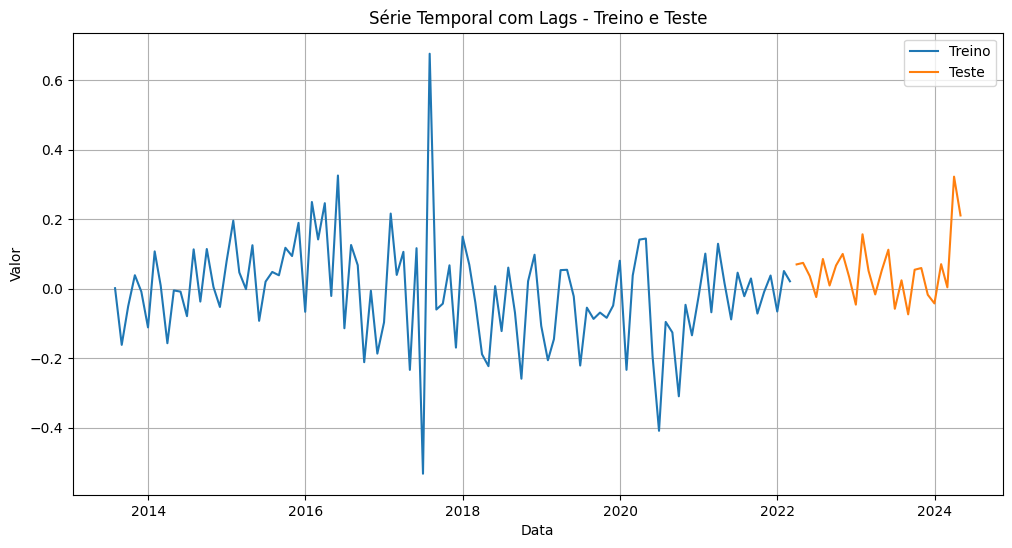

In [ ]:
##Las p/ árvores de decisao.

# Função para criar lags
def create_lags(series, n_lags):
    """
    Cria lags para uma série temporal.
    
    Args:
        series (pd.Series): Série temporal.
        n_lags (int): Número de lags (quantos meses defasados).
        
    Returns:
        pd.DataFrame: DataFrame com a série original e as colunas de lags.
    """
    df = pd.DataFrame(series)
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[series.name].shift(lag)
    df.dropna(inplace=True)  # Remove valores NaN criados pelos lags
    return df

# Número de lags
n_lags = 12

# Criar os lags para a série temporal
series_with_lags = create_lags(series, n_lags)

# Separar variáveis de entrada (X) e saída (y)
X = series_with_lags.iloc[:, 1:]  # Lags como entrada
y = series_with_lags.iloc[:, 0]   # Valor atual como saída

# Atualizar a separação de treino e teste com os lags
train_size = int(len(series_with_lags) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Visualizar os dados de treino e teste
print("X_train:\n", X_train.head())
print("y_train:\n", y_train.head())
print("X_test:\n", X_test.head())
print("y_test:\n", y_test.head())

# Plotar o conjunto de treino e teste com os lags
plot_train_test(y_train, y_test, 'Série Temporal com Lags - Treino e Teste')

## Extrapolaçao

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def predict_and_plot_future(model, series, steps, freq='M', model_name='Modelo'):
    """
    Faz previsões futuras e visualiza os resultados com dados históricos.

    Args:
        model: Modelo treinado com suporte ao método `.forecast` ou `.predict`.
        series (pd.Series): Série temporal original.
        steps (int): Número de períodos futuros para prever.
        freq (str): Frequência dos dados ('M' para mensal, 'D' para diário, etc.).
        model_name (str): Nome do modelo (para título do gráfico).
    
    Returns:
        pd.Series: Previsões futuras com índice temporal.
    """
    # Ajustar o modelo no conjunto completo da série
    model_fit = model.fit()

    # Previsões futuras
    future_forecast = model_fit.forecast(steps=steps)

    # Criar índice para previsões futuras
    future_index = pd.date_range(series.index[-1], periods=steps + 1, freq=freq)[1:]
    future_forecast = pd.Series(future_forecast, index=future_index)

    # Visualizar previsões com a série original
    plt.figure(figsize=(10, 5))
    plt.plot(series, label='Série Original')
    plt.plot(future_forecast, label='Previsões Futuras', color='red')
    plt.title(f'Previsão Futura com {model_name}')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid()
    plt.show()

    return future_forecast


## ARIMA

ARIMA(5, 1, 0) - AIC: -96.5830, BIC: -80.2720


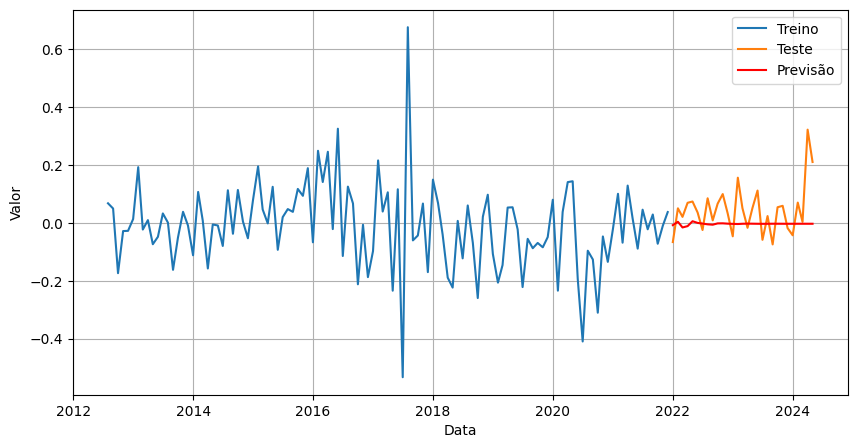

MSE: 0.0091
MAE: 0.0705
Teste de Ljung-Box:
      lb_stat  lb_pvalue
1   0.341000   0.559253
2   0.413049   0.813406
3   0.441069   0.931634
4   0.598037   0.963282
5   1.026071   0.960436
6   2.537136   0.864289
7   5.650398   0.581110
8   5.811103   0.668382
9   6.921713   0.645270
10  7.051780   0.720548
11  7.051780   0.794875
12  7.281568   0.838459
ARIMA(5, 1, 0) - AIC: -155.0945, BIC: -137.3595


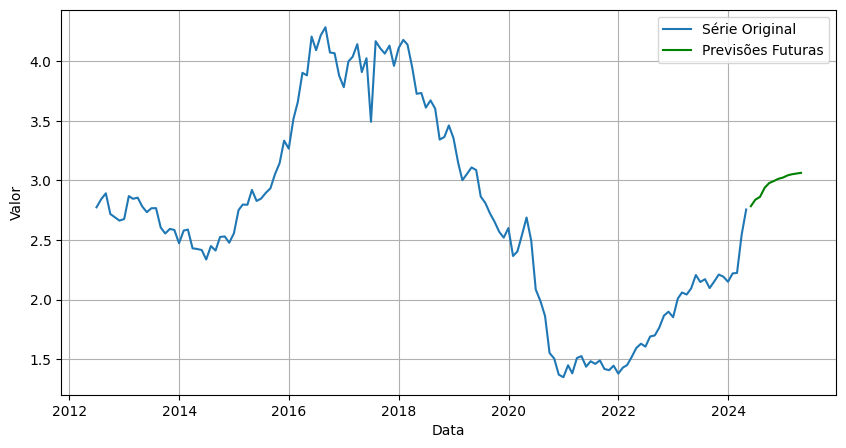

Previsões Futuras:
2024-05-31    2.783183
2024-06-30    2.837766
2024-07-31    2.861494
2024-08-31    2.937947
2024-09-30    2.977417
2024-10-31    2.994369
2024-11-30    3.012970
2024-12-31    3.023527
2025-01-31    3.042025
2025-02-28    3.050896
2025-03-31    3.057372
2025-04-30    3.062801
Freq: ME, Name: predicted_mean, dtype: float64


In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

# Função de previsão com ARIMA
def arima_forecast(train, test, order=(5, 1, 0)):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    
    # Imprimir AIC e BIC
    print(f"ARIMA{order} - AIC: {model_fit.aic:.4f}, BIC: {model_fit.bic:.4f}")
    
    return forecast

# Função para extrapolação
def extrapolate_future(series, steps, order=(5, 1, 0), freq='ME'):
    # Ajustar o modelo no conjunto completo
    model = ARIMA(series, order=order)
    model_fit = model.fit()

    # Imprimir AIC e BIC
    print(f"ARIMA{order} - AIC: {model_fit.aic:.4f}, BIC: {model_fit.bic:.4f}")

    # Previsões futuras
    future_forecast = model_fit.forecast(steps=steps)

    # Criar índice para previsões futuras
    future_index = pd.date_range(series.index[-1], periods=steps + 1, freq=freq)[1:]
    future_forecast = pd.Series(future_forecast, index=future_index)

    return future_forecast

# Avaliar previsões (MAE, MSE, AIC, BIC e Ljung-Box)
def evaluate_forecast(test, forecast, lags=10):
    residuals = test - forecast
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    ljung_box = acorr_ljungbox(residuals, lags=lags, return_df=True)

    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print("Teste de Ljung-Box:\n", ljung_box)

    return {"MSE": mse, "MAE": mae, "Ljung-Box": ljung_box}

# Plotar previsões
def plot_forecast(train, test, forecast):
    plt.figure(figsize=(10, 5))
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(test.index, forecast, label='Previsão', color='red')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid()
    plt.show()

# Garantir que o índice das séries seja temporal com frequência explícita
series.index = pd.date_range(start=series.index[0], end=series.index[-1], freq='ME')
train.index = pd.date_range(start=train.index[0], end=train.index[-1], freq='ME')
test.index = pd.date_range(start=test.index[0], end=test.index[-1], freq='ME')

# Forecast do conjunto de teste
forecast = arima_forecast(train, test)
plot_forecast(train, test, forecast)
evaluate_forecast(test, forecast, lags=12)

# Extrapolação de valores futuros
future_forecast = extrapolate_future(series, steps=12, order=(5, 1, 0), freq='ME')

# Plotar extrapolação
plt.figure(figsize=(10, 5))
plt.plot(series, label='Série Original')
plt.plot(future_forecast, label='Previsões Futuras', color='green')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

print("Previsões Futuras:")
print(future_forecast)

## SARIMA

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Melhores parâmetros encontrados: p=3, d=1, q=2, P=1, D=1, Q=2, s=12


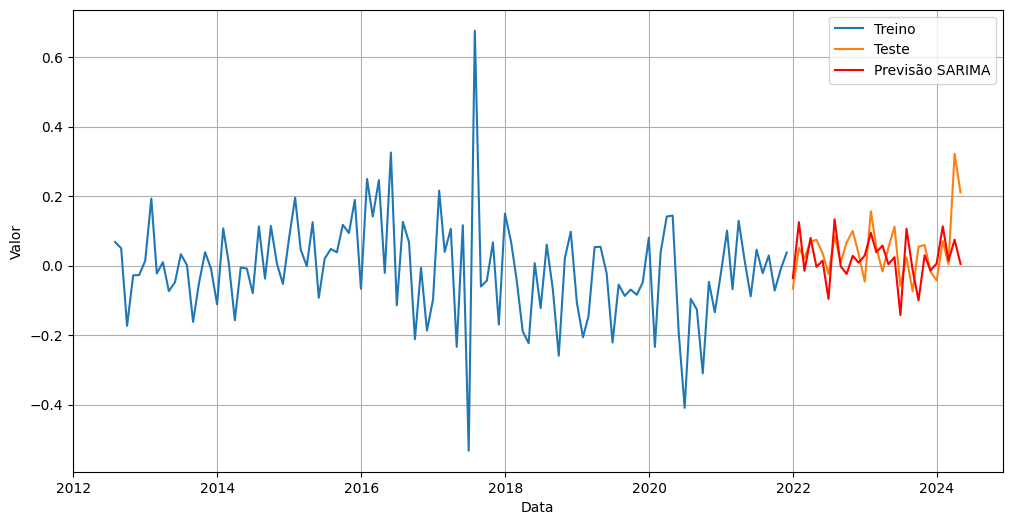

MSE: 0.0073
MAE: 0.0655

Teste de Ljung-Box (Autocorrelação dos resíduos):
     lb_stat  lb_pvalue
1   1.125152   0.288812
2   4.301910   0.116373
3   6.250829   0.100025
4   6.256422   0.180799
5   6.411807   0.268184
6   6.430620   0.376718
7   6.777152   0.452446
8   7.733389   0.459937
9   8.573560   0.477531
10  8.685342   0.562203


C:\Users\User\AppData\Local\Temp\ipykernel_9504\3609456916.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(series.index[-1], periods=steps + 1, freq=freq)[1:]


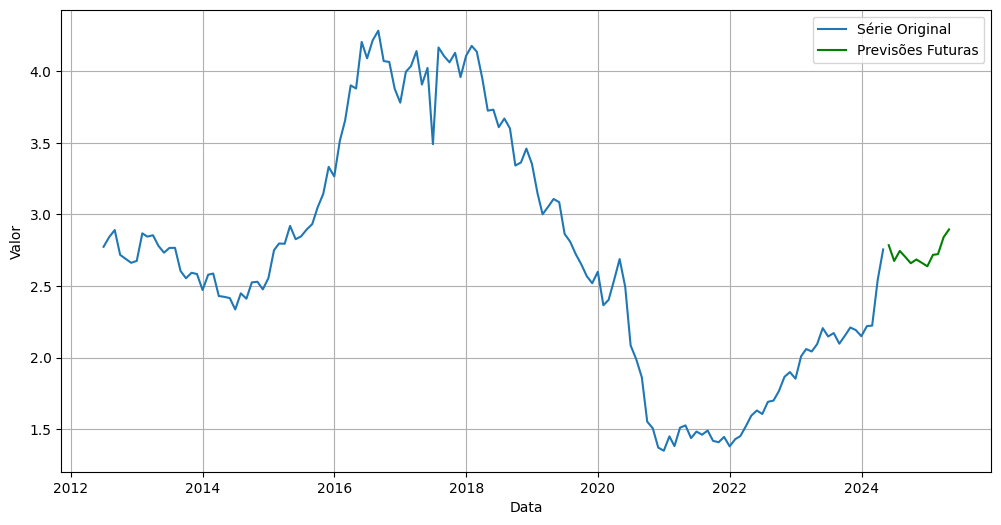

Previsões Futuras:
2024-05-31    2.785230
2024-06-30    2.675166
2024-07-31    2.744915
2024-08-31    2.702870
2024-09-30    2.659112
2024-10-31    2.685415
2024-11-30    2.662471
2024-12-31    2.637947
2025-01-31    2.717834
2025-02-28    2.722815
2025-03-31    2.841141
2025-04-30    2.895432
Freq: ME, Name: predicted_mean, dtype: float64


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox


# Função de previsão com SARIMA (com busca de melhores parâmetros)
def sarima_forecast_with_params(train, test):
    best_score, best_params = float("inf"), None
    for p in range(1, 4):
        for d in range(1, 2):
            for q in range(1, 4):
                for P in range(1, 3):
                    for D in range(1, 2):
                        for Q in range(1, 3):
                            for s in [6, 12]:
                                try:
                                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                    model_fit = model.fit(disp=False)
                                    forecast = model_fit.forecast(steps=len(test))
                                    score = mean_squared_error(test, forecast)
                                    if score < best_score:
                                        best_score = score
                                        best_params = (p, d, q, P, D, Q, s)
                                except Exception as e:
                                    print(f"Erro com parâmetros: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={s}: {e}")
                                    continue

    if best_params is None:
        raise ValueError("Nenhuma configuração válida de parâmetros encontrada.")
    
    # Ajustar o modelo com os melhores parâmetros encontrados
    p, d, q, P, D, Q, s = best_params
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    residuals = test - forecast
    print(f"Melhores parâmetros encontrados: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={s}")
    return pd.Series(forecast, index=test.index), residuals, best_params


# Teste de Ljung-Box
def ljung_box_test(residuals, lags=10):
    ljung_box_results = acorr_ljungbox(residuals, lags=lags, return_df=True)
    print("\nTeste de Ljung-Box (Autocorrelação dos resíduos):")
    print(ljung_box_results)
    return ljung_box_results


# Função para extrapolação de previsões futuras
def extrapolate_future_sarima(series, steps, seasonal_order, order=(1, 1, 1), freq='ME'):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    future_forecast = model_fit.forecast(steps=steps)
    future_index = pd.date_range(series.index[-1], periods=steps + 1, freq=freq)[1:]
    future_forecast = pd.Series(future_forecast, index=future_index)
    return future_forecast


# Avaliar previsões
def evaluate_forecast(test, forecast):
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    return mse, mae


# Plotar previsões
def plot_forecast(train, test, forecast, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(test.index, forecast, label=f'Previsão {model_name}', color='red')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()


# Aplicação
forecast, residuals, best_params = sarima_forecast_with_params(train, test)
plot_forecast(train, test, forecast, 'SARIMA')
evaluate_forecast(test, forecast)

# Aplicar Teste de Ljung-Box
ljung_box_results = ljung_box_test(residuals)

# Extrapolação de previsões futuras
future_forecast = extrapolate_future_sarima(
    series=series,
    steps=12,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    freq='M'
)

# Plotar extrapolação
plt.figure(figsize=(12, 6))
plt.plot(series, label='Série Original')
plt.plot(future_forecast, label='Previsões Futuras', color='green')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# Exibir as previsões futuras
print("Previsões Futuras:")
print(future_forecast)


## Decision Tree

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Melhor modelo: DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)
MSE: 0.0097
MAE: 0.0759
Teste de Ljung-Box:
       lb_stat  lb_pvalue
1    0.983836   0.321254
2    5.192859   0.074539
3    5.428591   0.142973
4    5.642787   0.227461
5    5.670103   0.339654
6    5.691016   0.458677
7    6.270532   0.508540
8    7.136942   0.521932
9    7.264221   0.609631
10   7.803695   0.648005
11  13.137386   0.284441
12  13.524693   0.332084


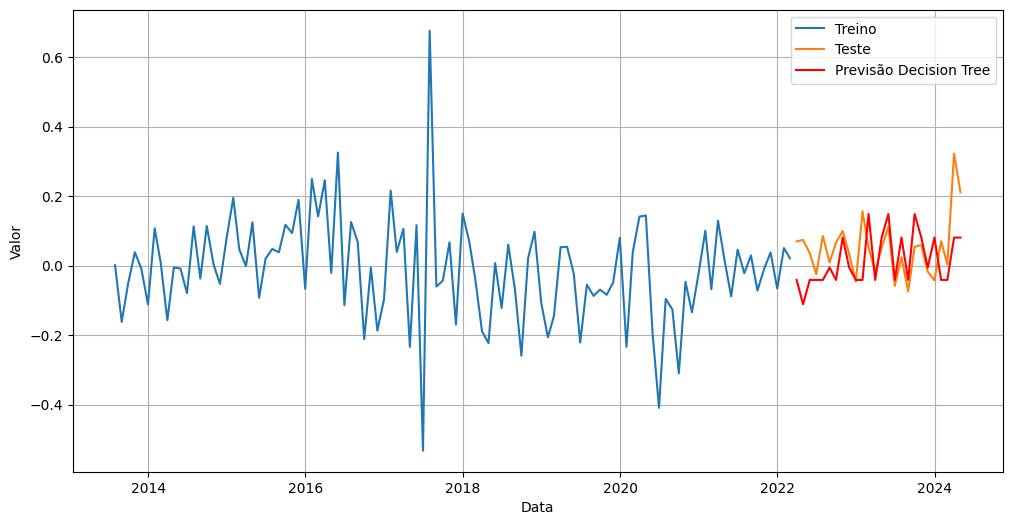

Previsões Futuras a partir de maio de 2024:
2013-07-31    0.002017
2013-08-31   -0.160019
2013-09-30   -0.210794
2013-10-31   -0.172439
2013-11-30   -0.181246
                ...   
2024-12-31    0.286761
2025-01-31    0.175268
2025-02-28    0.323722
2025-03-31    0.260794
2025-04-30    0.341410
Length: 142, dtype: float64


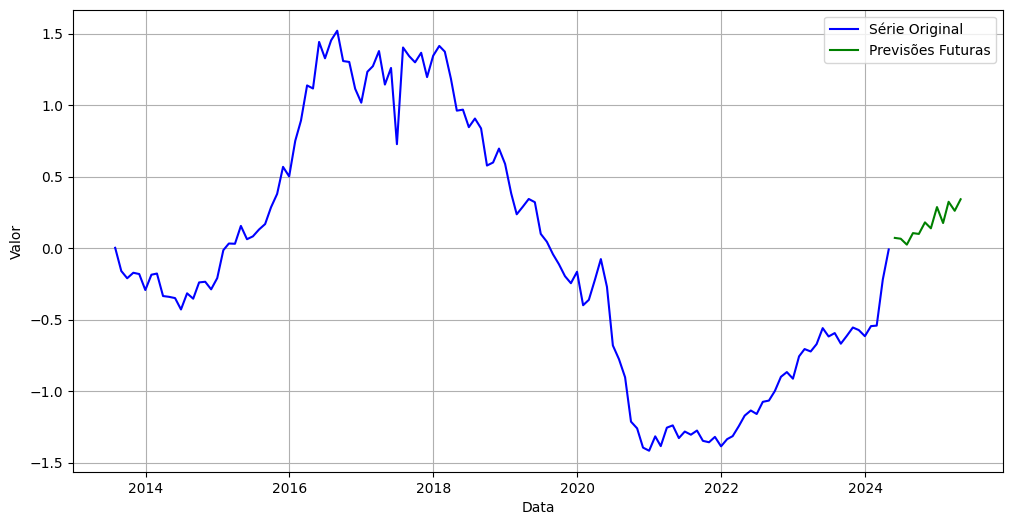

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.diagnostic import acorr_ljungbox

# Função de previsão com Árvore de Decisão usando janelas deslizantes
def decision_tree_forecast_with_lags(X_train, X_test, y_train, y_test):
    # Definição dos parâmetros para GridSearch
    param_grid = {
        'max_depth': [5, 10, 15, 20, 25],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 5, 10]
    }

    # Configuração do modelo
    dt = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Melhor estimador e previsões
    best_dt = grid_search.best_estimator_
    forecast = best_dt.predict(X_test)
    print("Melhor modelo:", best_dt)
    return pd.Series(forecast, index=y_test.index)

# Função para extrapolação de valores futuros
def extrapolate_future_decision_tree(model, X_train, steps, start_date, freq='ME'):
    # Últimos dados de entrada para começar a extrapolação
    last_input = X_train.iloc[-1].copy()
    future_forecast = []

    for _ in range(steps):
        # Prever o próximo valor
        next_value = model.predict(pd.DataFrame([last_input], columns=X_train.columns))[0]
        future_forecast.append(next_value)

        # Atualizar as entradas de lag com o valor previsto
        last_input = np.roll(last_input, -1)
        last_input[-1] = next_value

    # Criar índice temporal a partir da data de início
    future_index = pd.date_range(start=start_date, periods=steps, freq=freq)
    return pd.Series(future_forecast, index=future_index)

# Avaliar previsões com MAE, MSE e Teste de Ljung-Box
def evaluate_forecast(test, forecast, lags=10):
    residuals = test - forecast
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    ljung_box = acorr_ljungbox(residuals, lags=lags, return_df=True)

    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print("Teste de Ljung-Box:\n", ljung_box)

    return {"MSE": mse, "MAE": mae, "Ljung-Box": ljung_box}

# Plotar previsões separadas
def plot_forecast_separated(y_train, y_test, forecast, future_forecast, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, label='Treino')
    plt.plot(y_test, label='Teste')
    plt.plot(forecast.index, forecast, label=f'Previsão {model_name}', color='red')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

# Aplicar o modelo aos dados com janelas deslizantes
forecast = decision_tree_forecast_with_lags(X_train, X_test, y_train, y_test)

# Avaliação das previsões
evaluation_results = evaluate_forecast(y_test, forecast, lags=12)

# Ajustar modelo nos dados de treino
best_model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)
best_model.fit(X_train, y_train)

# Extrapolar valores futuros para 12 meses a partir de maio de 2024
future_steps = 12
start_date = "2024-05"
future_forecast = extrapolate_future_decision_tree(best_model, X_train, steps=future_steps, start_date=start_date, freq='ME')

# Visualizar previsões separadamente
plot_forecast_separated(y_train, y_test, forecast, future_forecast, 'Decision Tree')

print("Previsões Futuras a partir de maio de 2024:")
## Serie completa
y_series = pd.concat([y_train, y_test,future_forecast])
# Supor que `y_series` é a série diferenciada e você tem o valor inicial
initial_value = y_train.iloc[0]  # Primeiro valor da série original (antes da diferenciação)

# Reverter a diferenciação
y_series_original = y_series.cumsum() + initial_value

# Visualizar a série sem diferenciação
print(y_series_original)
# Supor que `y_series` já foi revertida para a escala original usando cumsum()
initial_value = y_train.iloc[0]  # Primeiro valor da série original (antes da diferenciação)
y_series_original = y_series.cumsum() + initial_value

# Separar o trecho futuro para destaque
start_forecast = "2024-05"  # Data de início das previsões futuras
future_data = y_series_original[y_series_original.index >= start_forecast]
past_data = y_series_original[y_series_original.index < start_forecast]

# Plotar a série completa
plt.figure(figsize=(12, 6))
plt.plot(past_data, label='Série Original', color='blue')
plt.plot(future_data, label='Previsões Futuras', color='green')
plt.title('')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


## Random Forest

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Melhor modelo: RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=12,
                      n_estimators=200, random_state=42)
MSE: 0.0083
MAE: 0.0657
Teste de Ljung-Box:
      lb_stat  lb_pvalue
1   0.676194   0.410900
2   1.085791   0.581063
3   1.157062   0.763320
4   1.186055   0.880389
5   1.229334   0.942032
6   2.604920   0.856546
7   4.158704   0.761327
8   5.510387   0.701889
9   6.525954   0.686341
10  6.584400   0.764011
11  6.628197   0.828344
12  6.724647   0.875261


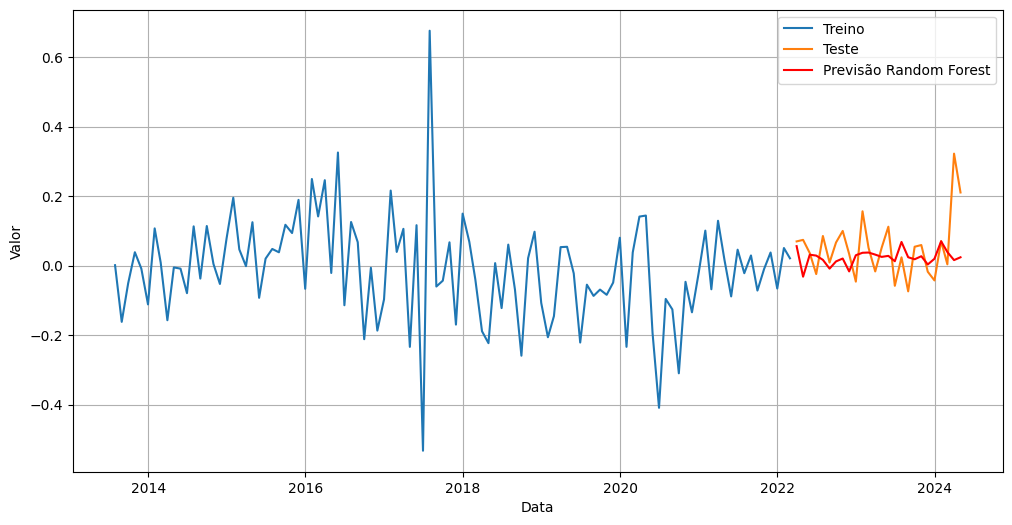

Previsões Futuras a partir de maio de 2024:
2024-05-31    0.017201
2024-06-30    0.000292
2024-07-31   -0.001103
2024-08-31    0.021859
2024-09-30    0.030173
2024-10-31    0.031827
2024-11-30    0.010028
2024-12-31    0.033455
2025-01-31    0.027528
2025-02-28    0.030324
2025-03-31    0.024583
2025-04-30    0.029572
Freq: ME, dtype: float64
2013-07-31    0.002017
2013-08-31   -0.160019
2013-09-30   -0.210794
2013-10-31   -0.172439
2013-11-30   -0.181246
                ...   
2024-12-31    0.134360
2025-01-31    0.161888
2025-02-28    0.192211
2025-03-31    0.216795
2025-04-30    0.246367
Length: 142, dtype: float64


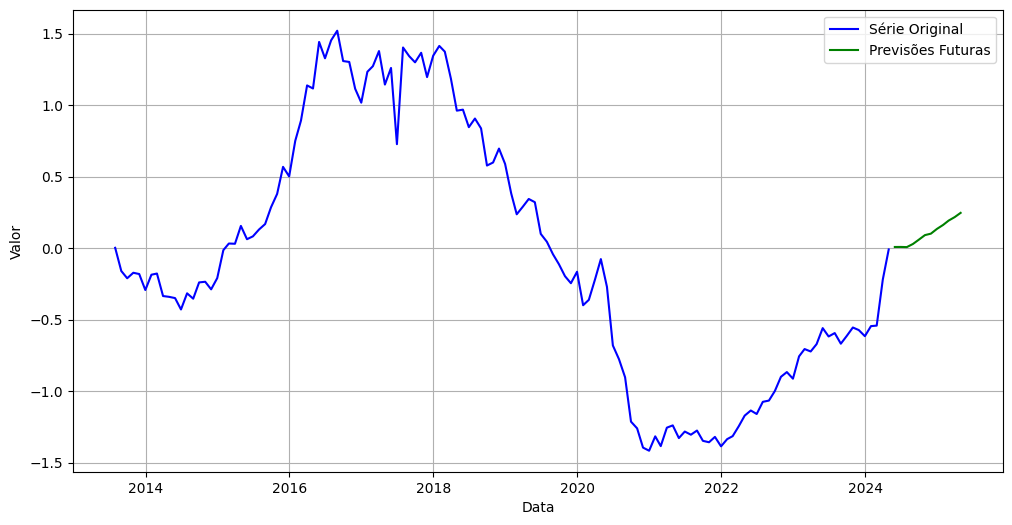

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.diagnostic import acorr_ljungbox

# Função de previsão com Random Forest usando janelas deslizantes
def random_forest_forecast_with_lags(X_train, X_test, y_train, y_test):
    # Definição dos parâmetros para GridSearch
    param_grid = {
        'n_estimators': [100, 150, 200, 250],
        'max_depth': [5, 10, 15, 20, 25],
        'min_samples_split': [2, 5, 10, 12],
        'min_samples_leaf': [1, 2, 4],
    }

    # Configuração do modelo
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Melhor estimador e previsões
    best_rf = grid_search.best_estimator_
    forecast = best_rf.predict(X_test)
    print("Melhor modelo:", best_rf)
    return pd.Series(forecast, index=y_test.index)

# Função para extrapolação de valores futuros
def extrapolate_future_random_forest(model, X_train, steps, start_date, freq='ME'):
    """
    Faz extrapolação de valores futuros usando Random Forest.

    Args:
        model: Modelo ajustado (RandomForestRegressor).
        X_train (pd.DataFrame): Entradas de treino (janelas deslizantes).
        steps (int): Número de períodos futuros a prever.
        start_date (str): Data inicial para as previsões (formato YYYY-MM).
        freq (str): Frequência dos dados ('ME' para mensal no final do mês).

    Returns:
        pd.Series: Previsões futuras com índice temporal.
    """
    last_input = X_train.iloc[-1].copy()
    future_forecast = []

    for _ in range(steps):
        next_value = model.predict(pd.DataFrame([last_input], columns=X_train.columns))[0]
        future_forecast.append(next_value)
        last_input = np.roll(last_input, -1)
        last_input[-1] = next_value

    future_index = pd.date_range(start=start_date, periods=steps, freq=freq)
    return pd.Series(future_forecast, index=future_index)

# Avaliar previsões com MAE, MSE e Teste de Ljung-Box
def evaluate_forecast(test, forecast, lags=10):
    residuals = test - forecast
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    ljung_box = acorr_ljungbox(residuals, lags=lags, return_df=True)

    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print("Teste de Ljung-Box:\n", ljung_box)

    return {"MSE": mse, "MAE": mae, "Ljung-Box": ljung_box}

# Plotar previsões separadas
def plot_forecast_separated(y_train, y_test, forecast, future_forecast, model_name):
    """
    Plota a série temporal com os valores de treino/teste em um gráfico e todas as previsões futuras no outro.

    Args:
        y_train (pd.Series): Saída do treino.
        y_test (pd.Series): Saída do teste.
        forecast (pd.Series): Previsões realizadas pelo modelo no conjunto de teste.
        future_forecast (pd.Series): Previsões futuras extrapoladas.
        model_name (str): Nome do modelo usado para as previsões.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_train, label='Treino')
    plt.plot(y_test, label='Teste')
    plt.plot(forecast.index, forecast, label=f'Previsão {model_name}', color='red')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()


# Aplicar o modelo aos dados com janelas deslizantes
forecast = random_forest_forecast_with_lags(X_train, X_test, y_train, y_test)

# Avaliação das previsões
evaluation_results = evaluate_forecast(y_test, forecast, lags=12)

# Ajustar modelo nos dados de treino
best_model = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=12, min_samples_leaf=4, random_state=42)
best_model.fit(X_train, y_train)

# Extrapolar valores futuros para 12 meses a partir de maio de 2024
future_steps = 12
start_date = "2024-05"
future_forecast = extrapolate_future_random_forest(best_model, X_train, steps=future_steps, start_date=start_date, freq='ME')

# Visualizar previsões separadamente
plot_forecast_separated(y_train, y_test, forecast, future_forecast, 'Random Forest')

print("Previsões Futuras a partir de maio de 2024:")
print(future_forecast)

## Serie completa
y_series = pd.concat([y_train, y_test,future_forecast])
# Supor que `y_series` é a série diferenciada e você tem o valor inicial
initial_value = y_train.iloc[0]  # Primeiro valor da série original (antes da diferenciação)

# Reverter a diferenciação
y_series_original = y_series.cumsum() + initial_value

# Visualizar a série sem diferenciação
print(y_series_original)
# Supor que `y_series` já foi revertida para a escala original usando cumsum()
initial_value = y_train.iloc[0]  # Primeiro valor da série original (antes da diferenciação)
y_series_original = y_series.cumsum() + initial_value

# Separar o trecho futuro para destaque
start_forecast = "2024-05"  # Data de início das previsões futuras
future_data = y_series_original[y_series_original.index >= start_forecast]
past_data = y_series_original[y_series_original.index < start_forecast]

# Plotar a série completa
plt.figure(figsize=(12, 6))
plt.plot(past_data, label='Série Original', color='blue')
plt.plot(future_data, label='Previsões Futuras', color='green')
plt.title('')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()
